In [1]:
import requests
from flask import Flask , request , jsonify
import pyodbc
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId
import threading
import time
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

2025-08-27 23:55:50.890 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 23:55:50.890 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 23:55:51.150 
  command:

    streamlit run C:\Users\Soft LapTop\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-27 23:55:51.151 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 23:55:51.151 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 23:55:51.165 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 23:55:51.165 Thread 'MainThread': missing ScriptRunContext! This warning

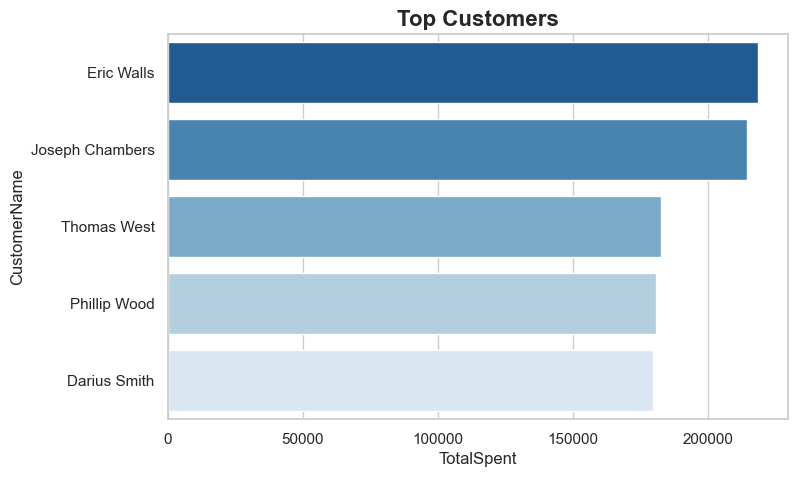

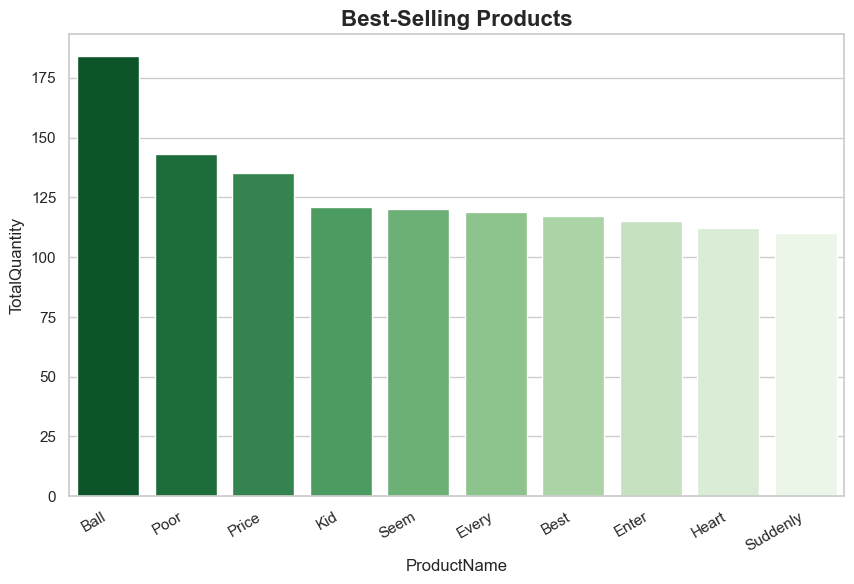

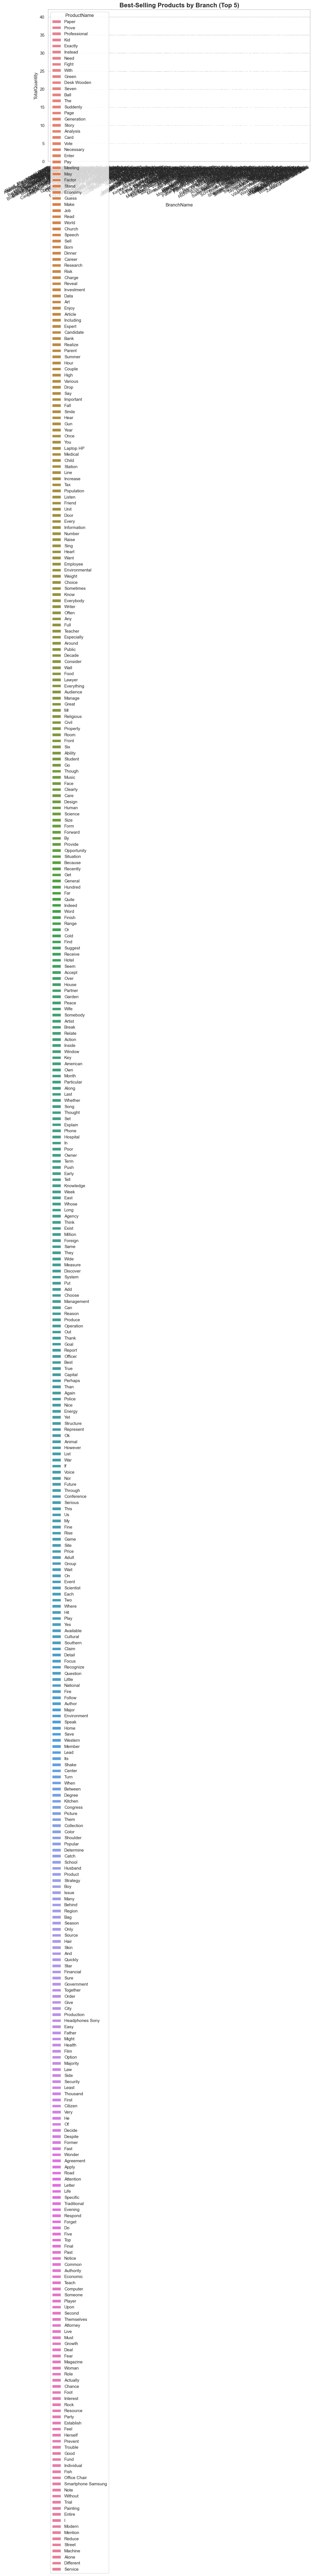

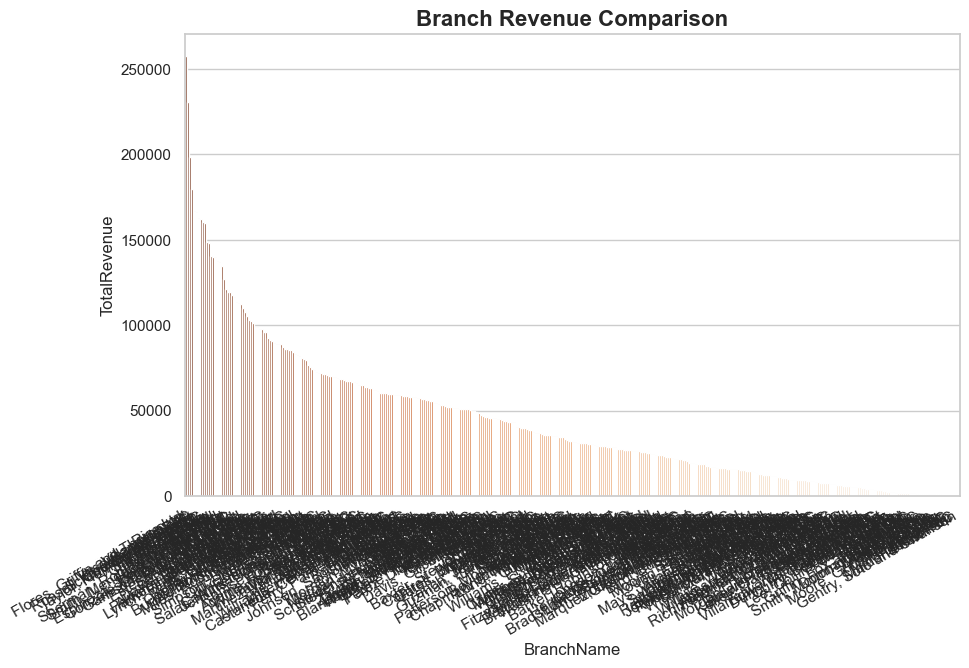

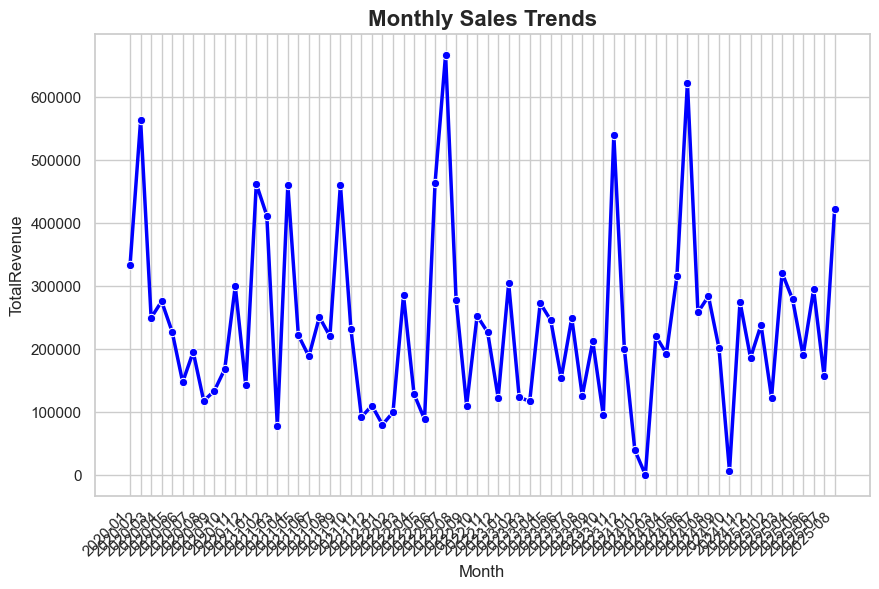

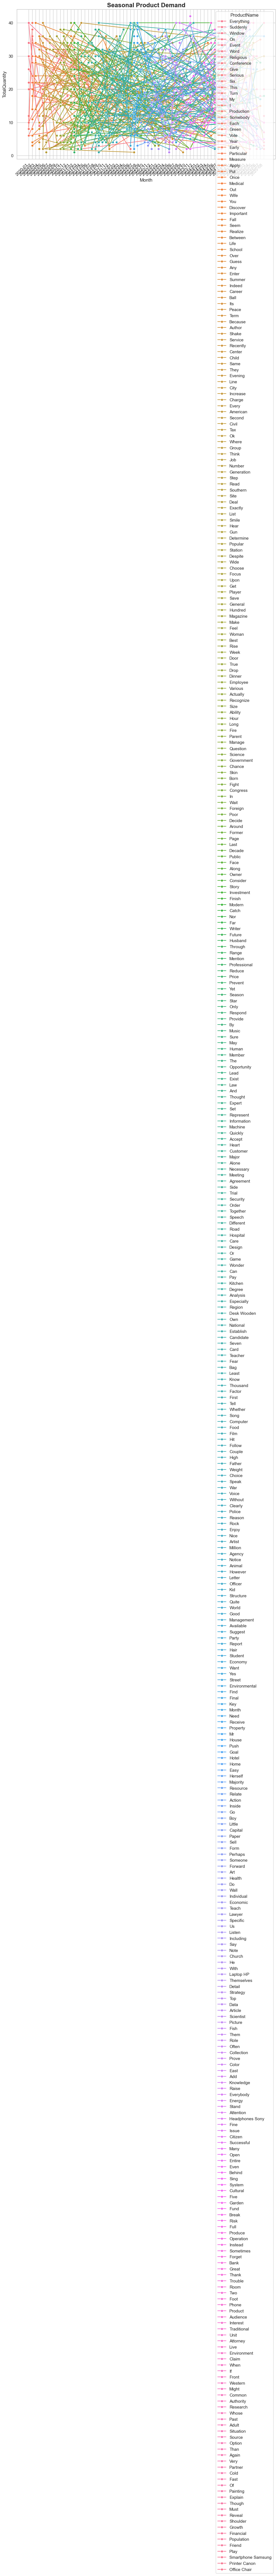

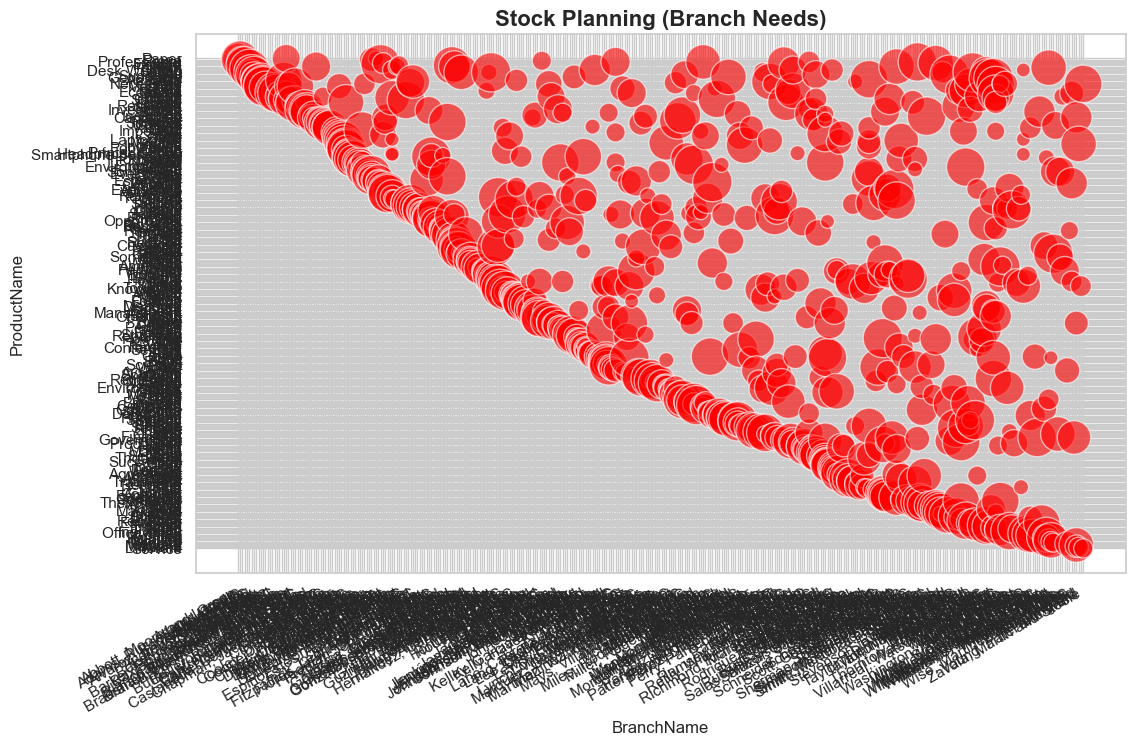

In [2]:
# -----------------------------
# Connect to MongoDB
# -----------------------------
client = MongoClient("mongodb://localhost:27017/")
db = client["MyDatabase"]

st.set_page_config(page_title="Retail Data Dashboard", layout="wide")
st.title("📊 Retail Data Analysis Dashboard")

sns.set_theme(style="whitegrid")  # شكل أنضف

# =============================
# Sidebar Filters
# =============================
branches = db["BranchRevenueComparison"].distinct("BranchName")
products = db["BestSellingProducts"].distinct("ProductName")
customers = db["TopCustomers"].distinct("CustomerName")

selected_branch = st.sidebar.selectbox("📍 Select Branch", ["All"] + branches)
selected_product = st.sidebar.selectbox("📦 Select Product", ["All"] + products)
selected_customer = st.sidebar.selectbox("👤 Select Customer", ["All"] + customers)

# -----------------------------
# 1. Top Customers
# -----------------------------
st.header("Top Customers (Highest Spenders)")
top_customers = list(db["TopCustomers"].find({}, {"_id": 0}))
if top_customers:
    df_top = pd.DataFrame(top_customers)
    if selected_customer != "All":
        df_top = df_top[df_top["CustomerName"] == selected_customer]

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x="TotalSpent", y="CustomerName", data=df_top, palette="Blues_r", ax=ax)
    ax.set_title("Top Customers", fontsize=16, fontweight="bold")
    st.pyplot(fig)


# -----------------------------
# 2. Best-Selling Products
# -----------------------------
st.header("Best-Selling Products (Overall)")
best_products = list(db["BestSellingProducts"].find({}, {"_id": 0}))
if best_products:
    df_products = pd.DataFrame(best_products)
    if selected_product != "All":
        df_products = df_products[df_products["ProductName"] == selected_product]

    df_products = df_products.head(10)  # نعرض Top 10 بس
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x="ProductName", y="TotalQuantity", data=df_products, palette="Greens_r", ax=ax)
    ax.set_title("Best-Selling Products", fontsize=16, fontweight="bold")
    plt.xticks(rotation=30, ha="right")
    st.pyplot(fig)


# -----------------------------
# 3. Best-Selling Products by Branch
# -----------------------------
st.header("Best-Selling Products by Branch (Top 5)")
branch_products = list(db["BestSellingProductsByBranch"].find({}, {"_id": 0}))
if branch_products:
    df_branch_products = pd.DataFrame(branch_products)
    if selected_branch != "All":
        df_branch_products = df_branch_products[df_branch_products["BranchName"] == selected_branch]

    df_branch_products = df_branch_products.sort_values(["BranchName", "TotalQuantity"], ascending=[True, False])
    df_branch_products = df_branch_products.groupby("BranchName").head(5)

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(x="BranchName", y="TotalQuantity", hue="ProductName", data=df_branch_products, ax=ax)
    ax.set_title("Best-Selling Products by Branch (Top 5)", fontsize=16, fontweight="bold")
    plt.xticks(rotation=30, ha="right")
    st.pyplot(fig)


# -----------------------------
# 4. Branch Revenue Comparison
# -----------------------------
st.header("Branch Revenue Comparison")
branch_revenue = list(db["BranchRevenueComparison"].find({}, {"_id": 0}))
if branch_revenue:
    df_branch_revenue = pd.DataFrame(branch_revenue)
    if selected_branch != "All":
        df_branch_revenue = df_branch_revenue[df_branch_revenue["BranchName"] == selected_branch]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x="BranchName", y="TotalRevenue", data=df_branch_revenue, palette="Oranges_r", ax=ax)
    ax.set_title("Branch Revenue Comparison", fontsize=16, fontweight="bold")
    plt.xticks(rotation=30, ha="right")
    st.pyplot(fig)


# -----------------------------
# 5. Monthly Sales Trends
# -----------------------------
st.header("Monthly Sales Trends")
monthly_trends = list(db["MonthlySalesTrends"].find({}, {"_id": 0}))
if monthly_trends:
    df_monthly = pd.DataFrame(monthly_trends)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x="Month", y="TotalRevenue", data=df_monthly, marker="o", linewidth=2.5, ax=ax, color="blue")
    ax.set_title("Monthly Sales Trends", fontsize=16, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    st.pyplot(fig)


# -----------------------------
# 6. Seasonal Product Demand
# -----------------------------
st.header("Seasonal Product Demand")
seasonal_demand = list(db["SeasonalProductDemand"].find({}, {"_id": 0}))
if seasonal_demand:
    df_seasonal = pd.DataFrame(seasonal_demand)
    if selected_product != "All":
        df_seasonal = df_seasonal[df_seasonal["ProductName"] == selected_product]

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.lineplot(x="Month", y="TotalQuantity", hue="ProductName", data=df_seasonal, marker="o", ax=ax)
    ax.set_title("Seasonal Product Demand", fontsize=16, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    st.pyplot(fig)


# -----------------------------
# 7. Stock Planning (Branch Needs)
# -----------------------------
st.header("Stock Planning (Branch Needs)")
stock_planning = list(db["StockPlanning"].find({}, {"_id": 0}))
if stock_planning:
    df_stock = pd.DataFrame(stock_planning)
    if selected_branch != "All":
        df_stock = df_stock[df_stock["BranchName"] == selected_branch]

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(x="BranchName", y="ProductName", size="TotalQuantity",
                    data=df_stock, sizes=(100, 800), alpha=0.6, ax=ax, legend=False, color="red")
    ax.set_title("Stock Planning (Branch Needs)", fontsize=16, fontweight="bold")
    plt.xticks(rotation=30, ha="right")
    st.pyplot(fig)
